<a href="https://colab.research.google.com/github/ShaneJasonViola/UFCFightPrediction/blob/main/FinalV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/ultimate-ufc-dataset
Files in dataset folder: ['upcoming.csv', 'ufc-master.csv']

📋 FULL CLASSIFICATION REPORTS FOR ALL MODELS

🧠 Model: Logistic Regression
📈 Training Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      1867
           1       0.60      0.58      0.59      1799

    accuracy                           0.60      3666
   macro avg       0.60      0.60      0.60      3666
weighted avg       0.60      0.60      0.60      3666


📊 Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       798
           1       0.60      0.57      0.59       774

    accuracy                           0.60      1572
   macro avg       0.60      0.60      0.60      1572
weighted avg       0.60      0.60      0.60      1572

------------------------------------------------------------
🧠 Model: Naive Bayes
📈 Tra

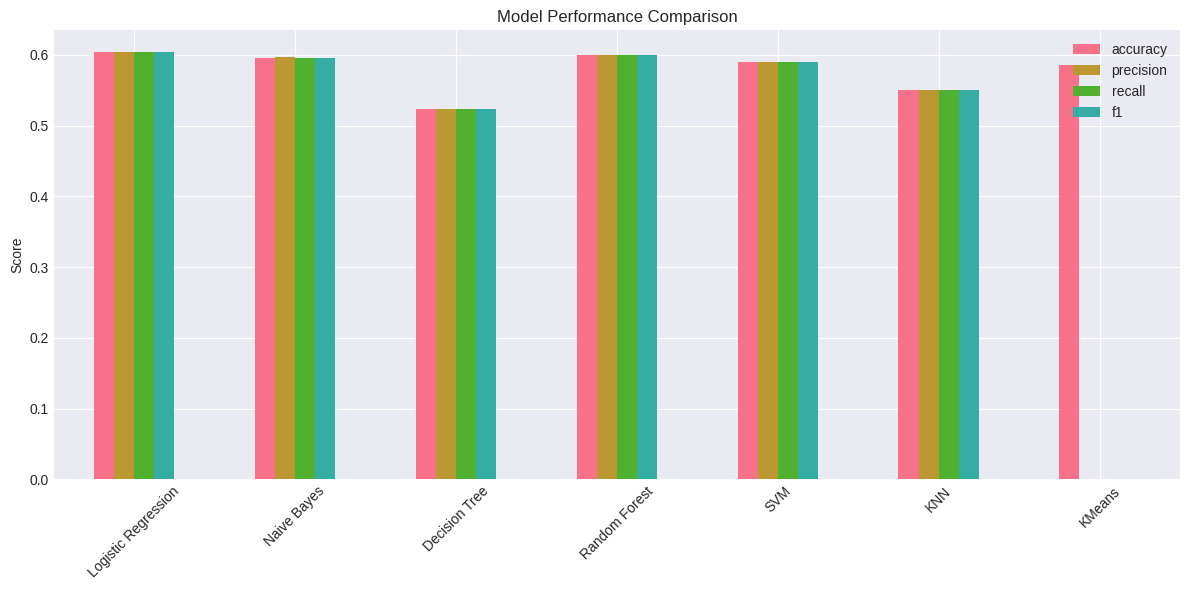

In [1]:
# UFC Fight Outcome Prediction Script (Final Version)

# 1. Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score
import warnings, os
import kagglehub

warnings.filterwarnings('ignore')
sns.set_palette('husl')
plt.style.use('seaborn-v0_8-darkgrid')

# 2. Load UFC Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdabbert/ultimate-ufc-dataset")

print("Path to dataset files:", path)

# List available files
print("Files in dataset folder:", os.listdir(path))

#Create DataFrame
file_path = os.path.join(path, 'ufc-master.csv')  # Replace with actual filename
ufc = pd.read_csv(file_path)


# 3. Flip Fighters Randomly into FighterA/B
np.random.seed(42)
flip_mask = np.random.rand(len(ufc)) < 0.5
red_cols = [col for col in ufc.columns if col.startswith("Red")]
blue_cols = [col for col in ufc.columns if col.startswith("Blue")]
ufc_flipped = ufc.copy()

for red_col, blue_col in zip(red_cols, blue_cols):
    base = red_col[3:]
    ufc_flipped[f"FighterA_{base}"] = np.where(flip_mask, ufc[red_col], ufc[blue_col])
    ufc_flipped[f"FighterB_{base}"] = np.where(flip_mask, ufc[blue_col], ufc[red_col])

ufc_flipped['FighterA_Win'] = np.where(
    (flip_mask & (ufc['Winner'] == 'Red')) | (~flip_mask & (ufc['Winner'] == 'Blue')),
    1, 0
)

# 4. Clean and Feature Engineer
drop_cols = [
    'Winner', 'Date', 'Location', 'Country', 'Finish', 'FinishDetails', 'FinishRound', 'FinishRoundTime',
    'TotalFightTimeSecs', 'BetterRank', 'RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue',
    'RedDecOdds', 'BlueDecOdds', 'RSubOdds', 'BSubOdds', 'RKOOdds', 'BKOOdds', 'EmptyArena',
    'BMatchWCRank', 'RMatchWCRank', 'Gender', 'FighterA_Fighter', 'FighterB_Fighter',
    'FighterA_Draws', 'FighterB_Draws',
    'FighterA_WinsByKO', 'FighterA_WinsByTKODoctorStoppage', 'FighterB_WinsByKO', 'FighterB_WinsByTKODoctorStoppage',
    'FighterA_WinsByDecisionUnanimous', 'FighterA_WinsByDecisionSplit', 'FighterA_WinsByDecisionMajority',
    'FighterB_WinsByDecisionUnanimous', 'FighterB_WinsByDecisionSplit', 'FighterB_WinsByDecisionMajority'
]

ufc_flipped['FighterA_WinsByKO_TKO'] = (
    ufc_flipped['FighterA_WinsByKO'] + ufc_flipped['FighterA_WinsByTKODoctorStoppage']
)
ufc_flipped['FighterB_WinsByKO_TKO'] = (
    ufc_flipped['FighterB_WinsByKO'] + ufc_flipped['FighterB_WinsByTKODoctorStoppage']
)

ufc_flipped['FighterA_WinsByDecision'] = (
    ufc_flipped['FighterA_WinsByDecisionUnanimous'] +
    ufc_flipped['FighterA_WinsByDecisionSplit'] +
    ufc_flipped['FighterA_WinsByDecisionMajority']
)
ufc_flipped['FighterB_WinsByDecision'] = (
    ufc_flipped['FighterB_WinsByDecisionUnanimous'] +
    ufc_flipped['FighterB_WinsByDecisionSplit'] +
    ufc_flipped['FighterB_WinsByDecisionMajority']
)

ufc_flipped['FighterA_WinRatio'] = ufc_flipped['FighterA_Wins'] / (
    ufc_flipped['FighterA_Wins'] + ufc_flipped['FighterA_Losses']
)
ufc_flipped['FighterB_WinRatio'] = ufc_flipped['FighterB_Wins'] / (
    ufc_flipped['FighterB_Wins'] + ufc_flipped['FighterB_Losses']
)

ufc_flipped['FighterA_Experience'] = ufc_flipped['FighterA_Wins'] + ufc_flipped['FighterA_Losses']
ufc_flipped['FighterB_Experience'] = ufc_flipped['FighterB_Wins'] + ufc_flipped['FighterB_Losses']

# Experience difference
ufc_flipped['ExperienceDiff'] = (
    ufc_flipped['FighterA_Experience'] - ufc_flipped['FighterB_Experience']
)

# Win ratio difference
ufc_flipped['WinRatioDiff'] = (
    ufc_flipped['FighterA_WinRatio'] - ufc_flipped['FighterB_WinRatio']
)

# 5. Calculate Feature Differences
ufc_flipped['AgeDiff'] = ufc_flipped['FighterA_Age'] - ufc_flipped['FighterB_Age']
ufc_flipped['ReachDiff'] = ufc_flipped['FighterA_ReachCms'] - ufc_flipped['FighterB_ReachCms']
ufc_flipped['TDLandedDiff'] = ufc_flipped['FighterA_AvgTDLanded'] - ufc_flipped['FighterB_AvgTDLanded']
ufc_flipped['SigStrPctDiff'] = ufc_flipped['FighterA_AvgSigStrPct'] - ufc_flipped['FighterB_AvgSigStrPct']
ufc_flipped['WinStreakDiff'] = ufc_flipped['FighterA_CurrentWinStreak'] - ufc_flipped['FighterB_CurrentWinStreak']

# 6. Final Dataset
selected_features = ['AgeDiff', 'ReachDiff', 'TDLandedDiff', 'SigStrPctDiff', 'WinRatioDiff', 'ExperienceDiff','WinStreakDiff','FighterA_WinRatio', 'FighterB_WinRatio']
df_model = ufc_flipped[selected_features + ['FighterA_Win']].dropna()

x = df_model[selected_features]
y = df_model['FighterA_Win']

# 7. Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# 8. Define Models with Pipelines
models = {
    "Logistic Regression": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ]),
    "Naive Bayes": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GaussianNB())
    ]),
    "Decision Tree": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', DecisionTreeClassifier())
    ]),
    "Random Forest": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=100))
    ]),
    "SVM": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', SVC())
    ]),
    "KNN": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    "KMeans": Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', KMeans(n_clusters=2, random_state=42))
    ])
}

# 9. Evaluate Models
results = {}
print("\n" + "="*60)
print("\U0001F4CB FULL CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*60 + "\n")

for name, model in models.items():
    print(f"\U0001F9E0 Model: {name}")
    if name == "KMeans":
        model.fit(x)
        pred = model.named_steps['model'].labels_
        pred = np.where(pred == pred[0], 1, 0)
        acc = accuracy_score(y, pred)
        results[name] = {'accuracy': acc}
        print(f"\U0001F535 KMeans Accuracy (full data): {acc:.2f}")
        print("-" * 60)
        continue

    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    train_report = classification_report(y_train, y_train_pred)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    results[name] = {
        'accuracy': test_report['accuracy'],
        'precision': test_report['weighted avg']['precision'],
        'recall': test_report['weighted avg']['recall'],
        'f1': test_report['weighted avg']['f1-score']
    }

    print("\U0001F4C8 Training Classification Report:")
    print(train_report)
    print("\n\U0001F4CA Test Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("-" * 60)

# 10. Compare Performance
results_df = pd.DataFrame(results).T
results_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation of all numeric columns with the target
correlation = ufc_flipped.corr(numeric_only=True)['FighterA_Win'].sort_values(ascending=False)

# Display top 20 positive correlations
print("🔝 Top 20 Positive Correlations with FighterA_Win:\n")
print(correlation.head(40).apply(lambda x: f"{x:.3f}"))

# Display top 20 negative correlations
print("\n🔻 Top 20 Negative Correlations with FighterA_Win:\n")
print(correlation.tail(40).apply(lambda x: f"{x:.3f}"))


🔝 Top 20 Positive Correlations with FighterA_Win:

FighterA_Win                    1.000
FighterB_Odds                   0.373
FighterB_ExpectedValue          0.343
FighterB_DecOdds                0.237
BPFPRank                        0.161
WinRatioDiff                    0.140
WinStreakDiff                   0.133
RWFlyweightRank                 0.130
RLightHeavyweightRank           0.128
TDLandedDiff                    0.125
SigStrPctDiff                   0.113
RPFPRank                        0.111
BFlyweightRank                  0.111
FighterB_Age                    0.102
FighterA_WinRatio               0.093
FighterA_AvgTDLanded            0.079
FighterA_AvgSigStrPct           0.079
FighterA_CurrentWinStreak       0.073
BHeavyweightRank                0.071
ReachDiff                       0.062
RBantamweightRank               0.055
FighterA_ReachCms               0.048
FighterA_AvgTDPct               0.043
FighterB_Losses                 0.040
BLightHeavyweightRank           0.038